In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from statsmodels.stats.power import TTestIndPower
from statsmodels.stats.power import FTestAnovaPower
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.power import TTestPower
from scipy import stats
from scipy.stats import f_oneway
import warnings
sys.path.append('../src/')
from stats import run_ANOVA_doses, plot_by_dose, doses_Tukey_HSD, get_ttest_wells, plot_by_wells, run_ANOVA_plates
from stats import plot_by_plate, plate_Tukey_HSD, run_ANOVA_cytokines, plot_by_cytokine, cytokine_Tukey_HSD
warnings.filterwarnings('ignore')

In [2]:
file = 'C:/Users/mdbla/Documents/UW_VM_Capstone_2024/HTI/Preprocessed_Data/Pam194_ObjCell_standard.csv'

clean_data = pd.read_csv(file, sep = ',')

clean_data.head()

,Unnamed: 0,ImageNumber,ObjectNumber,Metadata_Metadata_Cytokine,Metadata_Metadata_Dose,Metadata_Plate,Metadata_Well,AreaShape_Area,AreaShape_Orientation,Granularity_1_CorrActin,...,Texture_Contrast_CorrMito_3_02_256,Texture_Contrast_CorrMito_3_03_256,Texture_Contrast_CorrNileRed_3_00_256,Texture_Contrast_CorrNileRed_3_01_256,Texture_Contrast_CorrNileRed_3_02_256,Texture_Contrast_CorrNileRed_3_03_256,Texture_Contrast_CorrWGA_3_00_256,Texture_Contrast_CorrWGA_3_01_256,Texture_Contrast_CorrWGA_3_02_256,Texture_Contrast_CorrWGA_3_03_256
0,0,1,1,IFNg,33,Plate 1,B10,0.023633,0.162161,0.621509,...,0.066721,0.105668,0.004248,0.002979,0.003640,0.002365,0.027764,0.021816,0.039195,0.043983
1,1,1,2,IFNg,33,Plate 1,B10,0.201806,0.774438,0.685750,...,0.011581,0.014219,0.002751,0.002114,0.003533,0.002013,0.025764,0.019083,0.036872,0.036337
2,2,1,3,IFNg,33,Plate 1,B10,0.066095,0.644340,0.676748,...,0.034296,0.030419,0.008844,0.006727,0.010421,0.006714,0.075632,0.073224,0.095058,0.103654
3,3,1,4,IFNg,33,Plate 1,B10,0.126617,0.842324,0.606287,...,0.030470,0.021108,0.003947,0.003469,0.004755,0.002491,0.082486,0.092707,0.095009,0.067871
4,4,1,5,IFNg,33,Plate 1,B10,0.069745,0.896848,0.659443,...,0.034850,0.022948,0.002995,0.004340,0.006720,0.003295,0.039213,0.061849,0.101783,0.105671


In [3]:
# running some basic stats on the features

features = clean_data.iloc[:,7:]

features.describe().T

,count,mean,std,min,25%,50%,75%,max
AreaShape_Area,94370.0,0.060598,0.064582,0.0,0.019854,0.038939,0.076966,1.0
AreaShape_Orientation,94370.0,0.500640,0.256815,0.0,0.309798,0.500864,0.691352,1.0
Granularity_1_CorrActin,94370.0,0.621688,0.063817,0.0,0.579518,0.616982,0.658508,1.0
Granularity_1_CorrDNA2,94370.0,0.720556,0.128882,0.0,0.643399,0.744353,0.815829,1.0
Granularity_1_CorrGolgi,94370.0,0.561816,0.066838,0.0,0.518136,0.557315,0.600867,1.0
...,...,...,...,...,...,...,...,...
Texture_Contrast_CorrNileRed_3_03_256,94370.0,0.012618,0.022414,0.0,0.003513,0.006228,0.012546,1.0
Texture_Contrast_CorrWGA_3_00_256,94370.0,0.037386,0.050376,0.0,0.011802,0.021057,0.041001,1.0
Texture_Contrast_CorrWGA_3_01_256,94370.0,0.035189,0.048346,0.0,0.010398,0.019229,0.038606,1.0
Texture_Contrast_CorrWGA_3_02_256,94370.0,0.047232,0.061825,0.0,0.014945,0.027168,0.052991,1.0


# Statistical Analyses

#### These analyses should be conducted with a smaller set of features post-PCA 

In [4]:
cytokine_df = clean_data.iloc[:,np.r_[3:7,7:103]] # This data only contains our cytokine variable and featrues

cytokine_df.head()

,Metadata_Metadata_Cytokine,Metadata_Metadata_Dose,Metadata_Plate,Metadata_Well,AreaShape_Area,AreaShape_Orientation,Granularity_1_CorrActin,Granularity_1_CorrDNA2,Granularity_1_CorrGolgi,Granularity_1_CorrMito,...,Texture_Contrast_CorrMito_3_00_256,Texture_Contrast_CorrMito_3_01_256,Texture_Contrast_CorrMito_3_02_256,Texture_Contrast_CorrMito_3_03_256,Texture_Contrast_CorrNileRed_3_00_256,Texture_Contrast_CorrNileRed_3_01_256,Texture_Contrast_CorrNileRed_3_02_256,Texture_Contrast_CorrNileRed_3_03_256,Texture_Contrast_CorrWGA_3_00_256,Texture_Contrast_CorrWGA_3_01_256
0,IFNg,33,Plate 1,B10,0.023633,0.162161,0.621509,0.670366,0.541776,0.683105,...,0.085657,0.055899,0.066721,0.105668,0.004248,0.002979,0.003640,0.002365,0.027764,0.021816
1,IFNg,33,Plate 1,B10,0.201806,0.774438,0.685750,0.820995,0.549520,0.623303,...,0.010118,0.010156,0.011581,0.014219,0.002751,0.002114,0.003533,0.002013,0.025764,0.019083
2,IFNg,33,Plate 1,B10,0.066095,0.644340,0.676748,0.627520,0.558440,0.574556,...,0.026440,0.039005,0.034296,0.030419,0.008844,0.006727,0.010421,0.006714,0.075632,0.073224
3,IFNg,33,Plate 1,B10,0.126617,0.842324,0.606287,0.496211,0.570468,0.613697,...,0.026743,0.042283,0.030470,0.021108,0.003947,0.003469,0.004755,0.002491,0.082486,0.092707
4,IFNg,33,Plate 1,B10,0.069745,0.896848,0.659443,0.563880,0.542723,0.615665,...,0.016920,0.043490,0.034850,0.022948,0.002995,0.004340,0.006720,0.003295,0.039213,0.061849


### Group Difference: Average Values for Cytokines by Dosage (not including 'untr' or 'untr-50')

##### Method for Hypthesis testing: ANOVA & Tukey HSD

#### The following analysis consists of one-way ANOVA, which tests if there is a significant difference between any of the features for each cytokine

#### H0: M(11 ng/ml) = M(33 ng/ml) = M(100 ng/ml)

#### For this notebook, we'll be looking at cytokine IL26 and feature Granularity_1_CorrActin

In [5]:
cytokine='IL26'
feature='Granularity_1_CorrActin'

results = run_ANOVA_doses(cytokine, feature, cytokine_df)
print('The power for this One-Way ANOVA test is ' + str(results[1]))
print(results[0])

The power for this One-Way ANOVA test is 1.0
  Cytokine                  Feature     F-stat       P-value
0     IL26  Granularity_1_CorrActin  23.773958  5.141872e-11


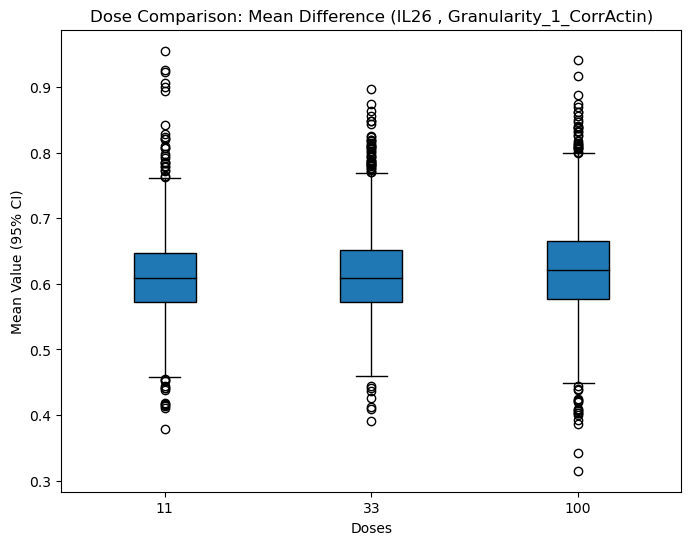

In [6]:
# Plot means of wells for each feature and each cytokine
results = plot_by_dose(cytokine, feature, cytokine_df)

##### The following Tukey HSD analysis is a pairwise t-test for each feature to see which pair of cytokine doses are significantly different from one another 

##### H0: For each of our selected features, dosage does not contribute to any significant difference in the averages for our cytokines

In [7]:
result = doses_Tukey_HSD(cytokine, feature, cytokine_df)
result.head()

,group1,group2,meandiff,p-adj,lower,upper,reject
1,11,33,0.0029,0.3128,-0.0018,0.0076,False
2,11,100,0.0127,0.0,0.0081,0.0172,True
3,33,100,0.0098,0.0,0.0053,0.0143,True


### Group Difference: Average Values for Cytokines by Wells

##### H0: For each of our selected features, our wells should not contribute to any significant difference in the averages for our cytokines

##### For this analysis, we'll only look at each cytokine at 100 ng/ml

##### Method for Hypthesis testing: t-test

In [8]:
results = get_ttest_wells(cytokine, feature, cytokine_df)

print(results)
#print(cytokine_df.isnull().any().sum().sum())

  Cytokine                  Feature Well Comparison  T-Statistic  p-value  \
0     IL26  Granularity_1_CorrActin        F2 vs G2        5.365      0.0   

   Power  
0    1.0  


##### The following supplementary plot is to visualize the mean difference across wells for a given cytokine and feature at 100 ng/ml

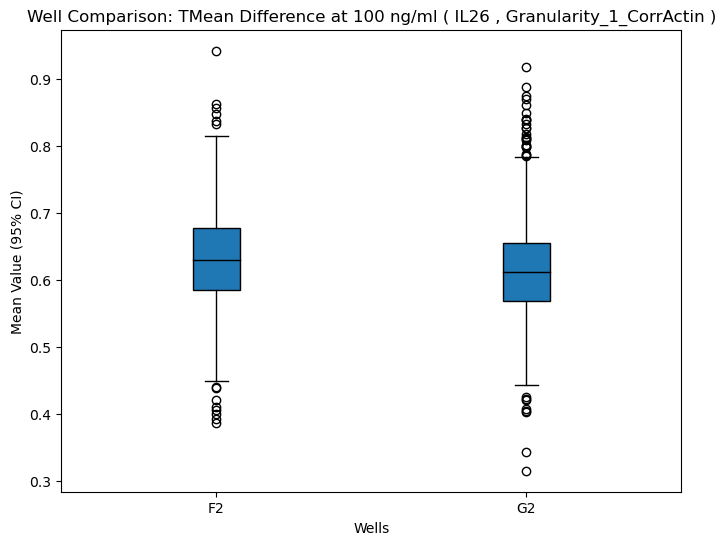

In [9]:
results = plot_by_wells(cytokine, feature, cytokine_df)

### Group Difference: Average Values for Untreated Cells by Plate

##### H0: For each of our selected features, the plates should not contribute to any significant difference in the averages for our untreated cells

#### Reminder: cytokines vary from plate to plate, but each plate is treated with the same untr and untr-50 cells

#### Similar to the analysis above, if any significant differences are detected, we shoud capture this in some way as it suggests that the mean differences that we observe may be contributed to contaminated plates or some external factor in the lab

##### Method for Hypthesis testing: ANOVA & Tukey-HSD

In [10]:
results = run_ANOVA_plates('untr', feature, cytokine_df)
print("The power for this ANOVA test is ", + results[1])
print(results[0])

The power for this ANOVA test is  1.0
  Cytokine                  Feature      F-stat        P-value
0     untr  Granularity_1_CorrActin  428.086047  2.305049e-176


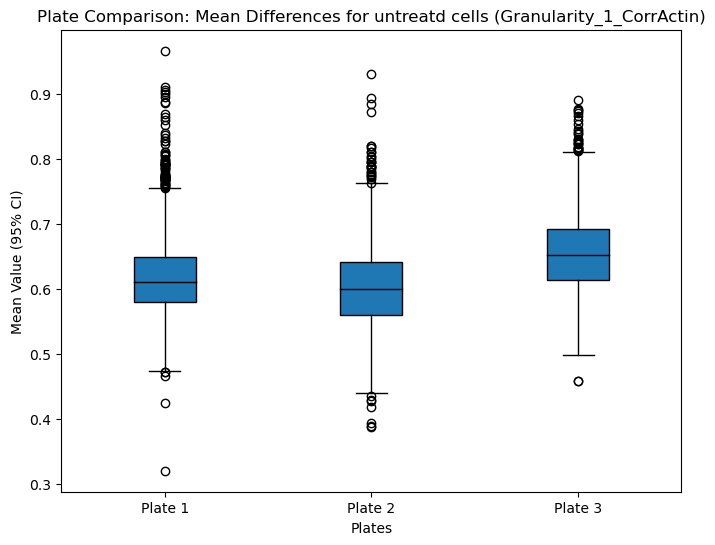

In [11]:
results = plot_by_plate('untr', feature, cytokine_df)

##### The following Tukey HSD analysis is a pairwise t-test for each feature to see which pair of plates have significantly different means among our untreated cells fore each features

##### H0: For each of our selected features, the plates does not contribute to any significant difference in the average feature mean for our untreated cells

In [12]:
result = doses_Tukey_HSD(cytokine, feature, cytokine_df)
print(result)
    

0 group1 group2 meandiff   p-adj   lower   upper reject
1     11     33   0.0029  0.3128 -0.0018  0.0076  False
2     11    100   0.0127     0.0  0.0081  0.0172   True
3     33    100   0.0098     0.0  0.0053  0.0143   True


### Group Difference: Average Values per Cytokine for a given feature

##### This final ANOVA/Tukey Analyses will seek to observe the differences in mean values for each of our cytokines at a given dosage treatment. 

#### H0: At the same dosage treatment, there is no difference between the mean values among our cytokines for a given feature

In [13]:
from statsmodels.stats.power import TTestPower
from scipy.stats import f_oneway

dose=100
feature='Granularity_1_CorrActin'

results = run_ANOVA_cytokines(cytokine_df, feature, dose)
print('The power for this One-Way ANOVA test is ' + str(results[1]))
print(results[0])

The power for this One-Way ANOVA test is 1.0
   Cytokine                  Feature      F-stat        P-value
0       100  Granularity_1_CorrActin  168.720519  6.589434e-313


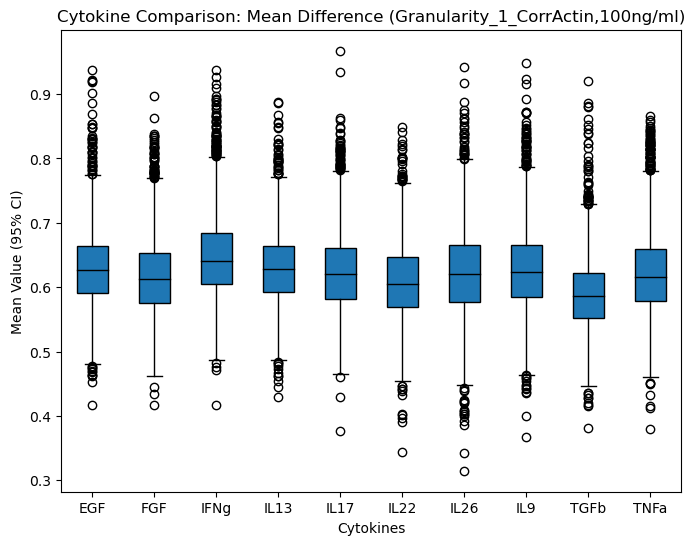

In [14]:
results = plot_by_cytokine(cytokine_df, feature, dose)

##### The following Tukey HSD analysis is a pairwise t-test for each feature to see which pair of cytokines have significantly different means among our features at a given dosage treatment.

##### H0: For each of our selected features, cytokines do not differ in mean value at a given dosage treatment

In [15]:

result = cytokine_Tukey_HSD(cytokine_df, feature, dose)
print(result)

0  group1 group2 meandiff   p-adj   lower   upper reject
1     EGF    FGF  -0.0125     0.0 -0.0177 -0.0072   True
2     EGF   IFNg   0.0182     0.0  0.0133  0.0231   True
3     EGF   IL13   0.0014  0.9988 -0.0042  0.0069  False
4     EGF   IL17  -0.0068  0.0016  -0.012 -0.0016   True
5     EGF   IL22  -0.0204     0.0 -0.0261 -0.0146   True
6     EGF   IL26  -0.0055  0.0411  -0.011 -0.0001   True
7     EGF    IL9  -0.0023  0.9248 -0.0074  0.0028  False
8     EGF   TGFb  -0.0403     0.0 -0.0456 -0.0349   True
9     EGF   TNFa  -0.0084     0.0 -0.0134 -0.0035   True
10    FGF   IFNg   0.0307     0.0  0.0257  0.0357   True
11    FGF   IL13   0.0139     0.0  0.0082  0.0195   True
12    FGF   IL17   0.0057  0.0238  0.0004   0.011   True
13    FGF   IL22  -0.0079  0.0008 -0.0137 -0.0021   True
14    FGF   IL26    0.007  0.0027  0.0014  0.0125   True
15    FGF    IL9   0.0102     0.0   0.005  0.0154   True
16    FGF   TGFb  -0.0278     0.0 -0.0332 -0.0223   True
17    FGF   TNFa    0.004  0.24